# Process of seasonal previsions - Test dataset

Data from March 2015 to August 2015.

In [1]:
import xarray as xr
ds = xr.open_dataset('/home/jovyan/data/forecast/c3s_seasonal/peru_north/pr/2015/03/c3s_seasonal_peru_north_pr_2015-03.nc')
ds

<xarray.Dataset>
Dimensions:    (longitude: 9, latitude: 11, number: 25, time: 6)
Coordinates:
  * longitude  (longitude) float32 -82.0 -81.0 -80.0 -79.0 ... -76.0 -75.0 -74.0
  * latitude   (latitude) float32 -3.4 -4.4 -5.4 -6.4 ... -11.4 -12.4 -13.4
  * number     (number) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
  * time       (time) datetime64[ns] 2015-03-01 2015-04-01 ... 2015-08-01
Data variables:
    tprate     (time, number, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-05 15:30:21 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

Overview of the begining time and the localisation.

In [65]:
import datetime

time_min = ds.time.min().values
time_min_dt = datetime.datetime.utcfromtimestamp(time_min.astype('O')/1e9)
year = time_min_dt.strftime('%Y')
month = time_min_dt.strftime('%m')
print(f'Dataset begins: year {year}, month {month}.')

Dataset begins: year 2015, month 03.


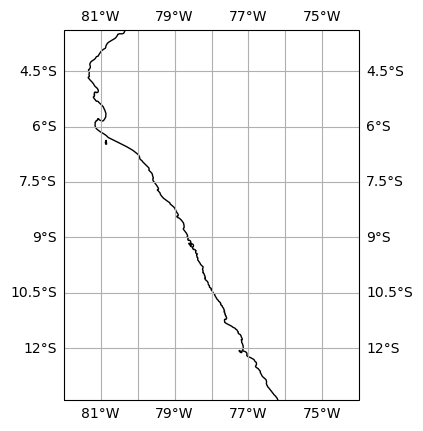

In [145]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

latitudes = ds['latitude'].values
longitudes = ds['longitude'].values

mean_lat = latitudes.mean()
mean_lon = longitudes.mean()
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=mean_lon))
ax.set_extent([longitudes.min(), longitudes.max(), latitudes.min(), latitudes.max()], crs=ccrs.PlateCarree())

ax.coastlines()
ax.gridlines(draw_labels=True)
plt.show()

Convert units: tprate (m/s) in tprate_mm_month (mm).

In [92]:
tprate = ds['tprate']

# Get the number of days in each month
nb_days = ds.time.dt.days_in_month

# m/s to mm/day
conversion_factor = 1e3 * 3600 * 24 

# Apply conversion
tprate_mm_month = tprate * conversion_factor * nb_days
tprate_mm_month = tprate_mm_month.rename('tprate_mm_month')
tprate_mm_month.attrs["units"] = "mm"

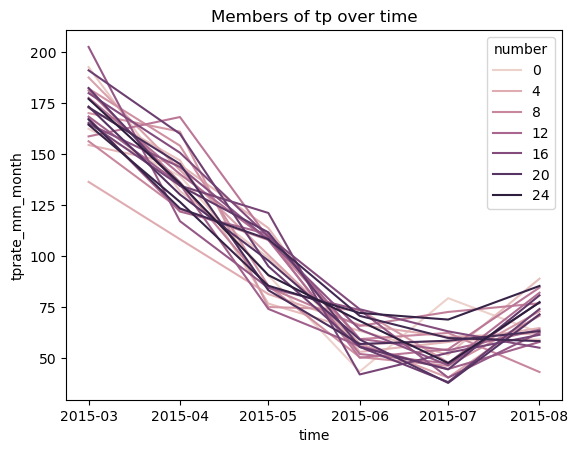

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

number_data = ds['number']
number_df = number_data.to_dataframe()
combined_data = tprate_mm_month.to_dataframe().join(number_df)

fig = plt.figure()
sns.lineplot(data=combined_data, x='time', y='tprate_mm_month', hue='number', errorbar=None)
plt.title("Members of tp over time")
plt.show()
fig.savefig(f'/home/jovyan/data/share/heloise/ESA-WP11/C3S/figures/tp_members_{year}_{month}.png')

Plot tp along latitude and longitude at time 0, for member 0.

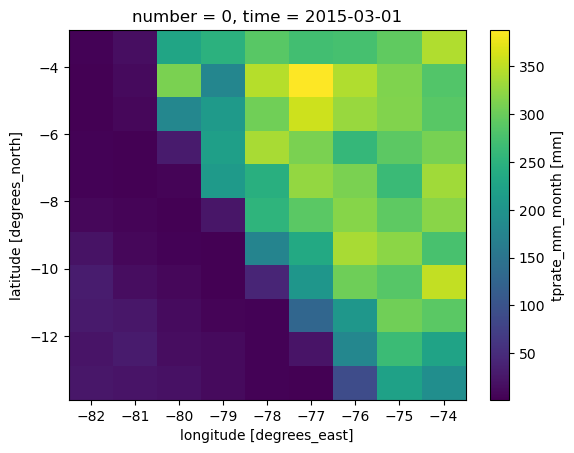

In [94]:
tprate_mm_month.isel(time=0, number=0).plot()

Select the tp members mean. (Quit number parameter from tp)

In [97]:
tp_member_mean = tprate_mm_month.mean(dim='number')
tp_member_mean.attrs["units"] = "mm"

Plot the tp members mean along latitude and longitude at time 0.

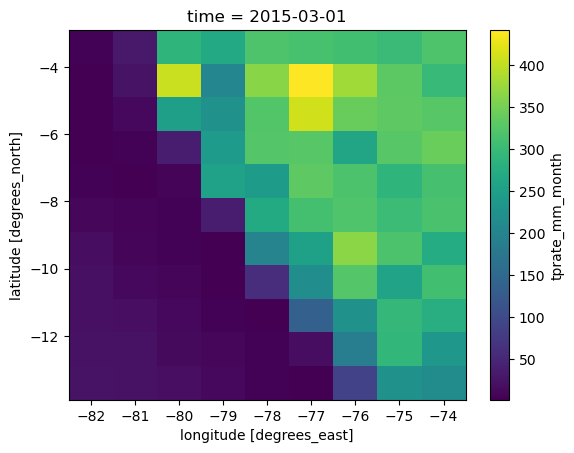

In [141]:
tp_member_mean.isel(time=0).plot()

Animation of the tp members mean along latitude, longitude over time.

In [136]:
list_path = []
for i in range(6):
    tp_member_mean.isel(time=i).plot()
    plt.title("Time = " + str(ds.time.values[i])[:13])
    frame = f"/home/jovyan/data/share/heloise/ESA-WP11/C3S/figures/tp_2d_time_{i:04}.png"
    list_path.append(frame)
    plt.savefig(frame)
    plt.close()

In [137]:
import imageio.v2 as imageio
ims = [imageio.imread(f) for f in list_path]
imageio.mimwrite(f'/home/jovyan/data/share/heloise/ESA-WP11/C3S/figures/tp_c3s_{year}_{month}.gif', ims)